<h2 style="text-align:center;"> Abnormal Parts </h2>

This notebook will re-implement the paper Unsupervised Anomaly Detection with Generative Adversarial Networks to Guide Marker
Discovery found at https://arxiv.org/pdf/1703.05921.pdf. 

#### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# set gpu devices
import os 
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # choose gpu's
os.environ['KERAS_BACKEND'] = 'tensorflow'

# for not draining all gpu in jupyter
import tensorflow as tf
import keras.backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

# extra
import cv2
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.mlab as mlab
from scipy import stats as st
import matplotlib.image as mpimg
import pandas as pd
from collections import defaultdict
from PIL import Image
import argparse
import math
try:
    import cPickle as pickle
except ImportError:
    import pickle
import numpy as np

# keras imports
import keras
from keras import backend as k
import keras.backend as K
from keras.utils.generic_utils import Progbar
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model, load_model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Dropout, Activation, Flatten, BatchNormalization, TimeDistributed, K
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD, Adam
# from keras import backend as K
from keras import metrics
from keras.datasets import mnist
K.set_image_data_format('channels_first')

Using TensorFlow backend.


In [2]:
# load the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalize
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = x_train.reshape((x_train.shape[0], 1) + x_train.shape[1:])

x_test = (x_test.astype(np.float32) - 127.5) / 127.5
x_test = x_test.reshape((x_test.shape[0], 1) + x_test.shape[1:])

print('Shape of our dataset x_train: {}, x_test: {}'.format(x_train.shape, x_test.shape))



Shape of our dataset x_train: (60000, 1, 28, 28), x_test: (10000, 1, 28, 28)


In [2]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, 1, image_size, image_size])
x_test = np.reshape(x_test, [-1, 1, image_size, image_size])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [21]:
x_train_normal.shape

(54051, 1, 28, 28)

In [4]:
x_train_neg.shape

(9216, 1, 28, 28)

In [3]:
x_train_pos = x_train[np.where(y_train == 9)]
x_t_neg = []
for i in range(8):
    x_t_neg_ = x_train[np.where(y_train == i)]
    x_t = x_t_neg_[:1152]
    x_t_2 = x_t_neg.append(x_t)
x_train_neg = np.reshape(np.asarray(x_t_neg), (8*1152,1,28,28))

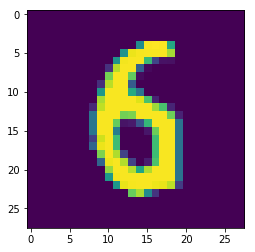

In [6]:
plt.imshow(np.squeeze(x_train_neg[7000]))

#### Filter normal and abnormal  

Fo training we need only "normal" elements without labels. In this step, we will remove from x_train all elements considered abnormal. For testing, we need both "normal" and "abnormal" with labels {0: abnormal, 1:normal}

The count of abnormal is significant less than the corpus of normal data

We are interested in not using the labels y_train of the elements, because the model is completely "unsupervised". Even the model expressed in the paper is called unsupervised, there is a pre filtering based on the labels presented. I haven't found at the moment a name for this. If a model has no labels as input we shall call it unsupervised learning.

Now that we have our data defined, we can move to the following steps:
1. Unsupervised Manifold Learning of Normal Anatomical Variability
2. Mapping new Images to the Latent Space
3. Detection of Anomalies

### 1. Unsupervised Manifold Learning of Normal Anatomical Variability

We use a deconvolution generative adversarial network (DCGAN) for learning the manifold of $\mathcal{X}$ which represents the variablity of our training images. We will base the implementation on  https://github.com/jacobgil/keras-dcgan/blob/master/dcgan.py with some modifications. For completeness, we leave the link to the DCGAN paper https://arxiv.org/abs/1511.06434

#### Helper functions

Plot functions

Create folders to store the training results for reuse:

#### Model

Define the generator and discriminator and visualize both models:

In [6]:
def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=100, output_dim=1024))
    model.add(Activation('tanh'))
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Reshape((128, 7, 7), input_shape=(128*7*7,)))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Convolution2D(64, 5, 5, border_mode='same'))
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Convolution2D(1, 5, 5, border_mode='same'))
    model.add(Activation('tanh'))
    return model

def discriminator_model():
    model = Sequential()
    model.add(Convolution2D(
                        64, 5, 5,
                        border_mode='same',
                        input_shape=(1, 28, 28)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(128, 5, 5))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

def generator_containing_discriminator(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

In [7]:
generator_model().summary()

/cadappl/python3/anaconda-3.5.1/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=1024)`
  This is separate from the ipykernel package so we can avoid doing imports until
/cadappl/python3/anaconda-3.5.1/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              103424    
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
activation_2 (Activation)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 14, 14)       0         
__________

/cadappl/python3/anaconda-3.5.1/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (5, 5), padding="same")`
  del sys.path[0]


In [8]:
discriminator_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 28, 28)        1664      
_________________________________________________________________
activation_5 (Activation)    (None, 64, 28, 28)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 10, 10)       204928    
_________________________________________________________________
activation_6 (Activation)    (None, 128, 10, 10)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 5, 5)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
__________

/cadappl/python3/anaconda-3.5.1/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(1, 28, 28..., padding="same")`
/cadappl/python3/anaconda-3.5.1/lib/python3.5/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5))`


#### Train

#### Testing score

For testing purpose, we use data $\mathcal{J}$ containing unseen data points during training and with labels $\mathcal{l} \in \{0, 1\}$ representing 1 normal and 0 abnormal. The paper does not specify this assignation, but we can infer it from looking at the dcgan implementation since the fake images are assigned with a value of 0 when training the discriminator.

In [9]:
%%capture --no-stdout
# load the discriminator
discriminator = discriminator_model()
discriminator.load_weights('Weights/dcgan_mnist_discriminator.hdf5')

# load the generator
generator = generator_model()
generator.load_weights('Weights/dcgan_mnist_generator.hdf5')

In [10]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 28, 28)        1664      
_________________________________________________________________
activation_9 (Activation)    (None, 64, 28, 28)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 10, 10)       204928    
_________________________________________________________________
activation_10 (Activation)   (None, 128, 10, 10)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 5, 5)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
__________

Choose someone from x_test that we want to spot the differences. We can work with a normal one and an abnormal.

In [11]:
idx_choosen_one = 500 # index of element for mapping to the latent space


Display $x$ and $G(z_{1})$

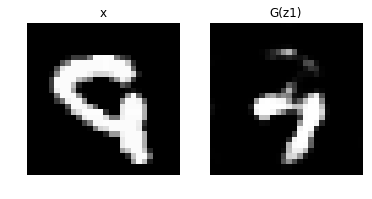

In [12]:
# select x and z1
x = x_train_pos[idx_choosen_one]
z = z1 = np.random.uniform(-1, 1, (1, 100)) #(1 image, latent_size)
g_z = g_z1 = generator.predict(z1) # G(z1)

# plot
names = ['x', 'G(z1)']
images = [np.squeeze(x), np.squeeze(g_z1)]
plt.figure(1)
for idx in range(2):
    plt.subplot(1, 2, idx+1)
    plt.axis('off')
    plt.title(names[idx])
    plt.imshow(images[idx], cmap=plt.get_cmap('gray'))
plt.show()

Define $f(x)$, output of the discriminator until some layer.

In [13]:
# display layer options
idx_layer = 8 # layer selected
# do not use negative numbers because we will loop them further in the notebook
discriminator.layers

In [14]:
discriminator.layers[0].input

<tf.Tensor 'conv2d_5_input:0' shape=(?, 1, 28, 28) dtype=float32>

In [15]:
# discriminator model until some layer f
layer_input = discriminator.layers[0].input
layer_output = discriminator.layers[idx_layer].output
get_feature_output = K.function([layer_input, K.learning_phase()],
                               [layer_output])

In [16]:
# obtain f(x) 
# x.shape must be (None, 1, 28, 28) but we have (1, 28, 28)
# expand dimensions to fix it
x_expand = np.expand_dims(x, axis=1)
f_x = get_feature_output([x_expand, 0])[0] # [x, 0] is input, phase train '1' vs test '0'

Create a model that returns $G(z_{i})$ and $f(G(z_{i}))$

In [17]:
d_input = g_output = generator.layers[-1].output
for i in range(idx_layer+1): # 0,1,...,idx_layer
    d_input = discriminator.layers[i](d_input)
model_gd_2outputs = Model(input=generator.input, output=[g_output, d_input])

/cadappl/python3/anaconda-3.5.1/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("de...)`
  after removing the cwd from sys.path.


Construct the $\textbf{overall loss}$ using the two previous ingredients.

In [18]:
# check shapes are the same 
model_gd_2outputs.output[0][:, 0, :, :], x[0].shape,model_gd_2outputs.output[1], f_x.shape

(<tf.Tensor 'strided_slice:0' shape=(?, 28, 28) dtype=float32>,
 (28, 28),
 <tf.Tensor 'activation_11_1/Tanh:0' shape=(?, 1024) dtype=float32>,
 (1, 1024))

In [19]:
# parameter
_lambda = 0.1

# overall loss
residual_loss = K.mean(k.abs(model_gd_2outputs.output[0][:, 0, :, :] - x[0]))
discriminator_loss =  K.mean(k.abs(model_gd_2outputs.output[1] - f_x[0])) 
overall_loss = (1-_lambda)*(residual_loss) + _lambda*(discriminator_loss)

$\textbf{Gradient descent}$ steps $1, 2, ..., \gamma$ to minimize the loss

In [20]:
# create iterator for gradients
input_noise = model_gd_2outputs.input
grads = K.gradients(overall_loss, input_noise)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
iterate = K.function([input_noise, K.learning_phase()], [overall_loss, grads])

In [82]:
z = z1.copy()
step = 1 # here we could reduce the steps over time?
nb_descents = 300

# run gradient descent for 20 steps
for i in range(nb_descents):
    loss_value, grads_value = iterate([z, 0])
    z -= grads_value * step

In [26]:
save_weights = True
save_loss = True
batch_size = 128
epochs = 50
latent_size = 100
latent_dim = 100
LR = 0.0005
momentum = 0.9 #0.5
_lambda = 0.1
step = 1
nb_descents = 100
def predict(x):
       ##### Parameters
        z1 = np.random.uniform(-1, 1, (batch_size, latent_dim))
        
        ##### Overall loss
        x_expand = np.expand_dims(x, axis=1) # x.shape must be (None, 1, 28, 28) but we have (1, 28, 28)
                                             # if its a single element we need to expand, otherwise leave it
        f_x = get_feature_output([x_expand, 0])[0] # [x, 0] is input, phase train '1' vs test '0'

        # Loss definition
        residual_loss = K.mean(k.abs(model_gd_2outputs.output[0][:, 0, :, :] - x[0]))
        discriminator_loss =  K.mean(k.abs(model_gd_2outputs.output[1] - f_x[0])) 
        overall_loss = (1-_lambda)*(residual_loss) + _lambda*(discriminator_loss)
        
        # Gradients steps
        input_noise = model_gd_2outputs.input
        grads = K.gradients(overall_loss, input_noise)[0]
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
        iterate = K.function([input_noise, K.learning_phase()], [overall_loss, grads])
        
        # loop n gradients steps
        z = z1.copy()
        for i in range(nb_descents):
            loss_value, grads_value = iterate([z, 0])
            z -= grads_value * step

        return loss_value, generator.predict(z)

In [38]:
def scores(x_batch):
        return [predict(x)[0] for x in x_batch]

In [30]:
x_train_neg_shuffle = np.random.shuffle(x_train_neg)

In [37]:
type(x_train_pos)

numpy.ndarray

In [39]:
scores_neg = scores(x_train_neg[:100])
scores_pos = scores(x_train_pos[:100])

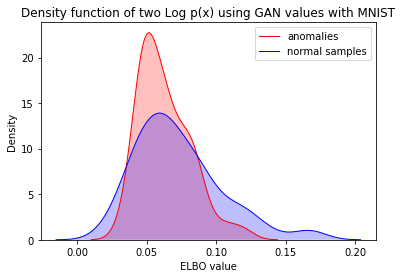

In [40]:
import seaborn as sns
plt.figure()
ax1 = sns.distplot(scores_pos , hist = False, kde = True,
                 kde_kws = {'linewidth': 1, 'shade':True}, label='anomalies',color="red")
ax2 = sns.distplot(scores_neg , hist = False, kde = True,
                 kde_kws = {'linewidth': 1, 'shade':True}, label='normal samples', color= "blue")



plt.title('Density function of two Log p(x) using GAN values with MNIST')
plt.xlabel('ELBO value')
plt.ylabel('Density')
plt.legend()

In [41]:
y_true_neg = np.zeros([100,1])
y_true_pos = np.ones([100,1])
y_true = np.concatenate((y_true_neg, y_true_pos))

scores_total = np.concatenate((scores_neg, scores_pos))

In [42]:
np.save('x_train_likelihood_mnist_gan', scores_total)
np.save('y_train_mnist_gan', y_true)

Plot image we are interested to explore $x$, our initial random image $G(z_{1})$ and $G(z_{\gamma})$ after $\gamma$ steps.

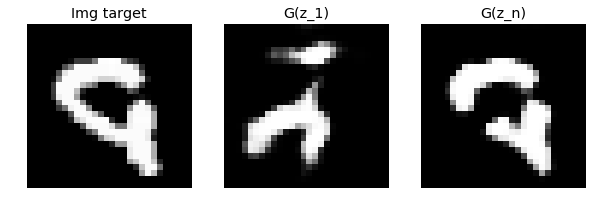

In [83]:
x_img = x.squeeze()
g_z1 = generator.predict(z1).squeeze()
g_zn = generator.predict(z).squeeze()

images = [x_img, g_z1, g_zn]
names = ['Img target', 'G(z_1)', 'G(z_n)']

plt.figure(figsize=(10, 6))
plt.figure(1)
for idx in range(3):
    plt.subplot(1, 3, idx+1)
    plt.axis('off')
    plt.title(names[idx])
    plt.imshow(images[idx], cmap=plt.get_cmap('gray'))
plt.show()

Remarks

Recall number 7 is not part of the unsupervised learning and after 300 descent steps we get $G(z_{\gamma})$. We could approximate from different initializations the target image by changing z1. Also, how about visualizing 10 steps before arriving to the target image to visualize around this manifold $\mathcal{X}$